In [3]:
from peak_utilities import generate_waveform, create_dataframe
import matplotlib.pyplot as plt

In [4]:
noise_mean = 12
noise_std = 0.5

peak = generate_waveform([100, 130, 500], [50, 50, 50], 15, 30, 
                         noise_mean=noise_mean, noise_std=noise_std, 
                         nsamples=1000)

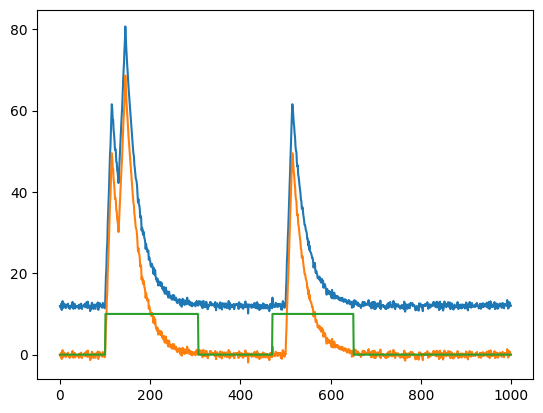

In [5]:
df_waveform = create_dataframe(peak)

plt.plot(df_waveform['Bin'], df_waveform['Waveform'])
plt.plot(df_waveform['Bin'], df_waveform['WaveformOffset'])
plt.plot(df_waveform['Bin'], ~df_waveform['Baseline'] * 10)
plt.show()